In [ ]:
# prophet package name varies: "prophet" or "fbprophet" depending on environment.
# ydata_profiling is modern replacement for pandas_profiling.
!pip install -q ydata-profiling plotly wordcloud nltk scikit-learn matplotlib seaborn
# prophet can be heavy; try install but allow fallback
!pip install -q prophet || pip install -q fbprophet || true

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.8 MB/s eta 0:00:00


In [ ]:
import os, io, re, warnings, math
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, classification_report

from scipy.stats import chi2_contingency, zscore
# For Cramer's V
import scipy.stats as stats

In [ ]:
import plotly.express as px

In [ ]:
# NLP tools
import nltk
from wordcloud import WordCloud, STOPWORDS
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Profiling
from ydata_profiling import ProfileReport

# Try prophet
HAS_PROPHET = False
try:
    from prophet import Prophet
    HAS_PROPHET = True
except:
    try:
        from fbprophet import Prophet
        HAS_PROPHET = True
    except:
        HAS_PROPHET = False

print("Libraries loaded. Prophet available:", HAS_PROPHET)

Libraries loaded. Prophet available: True


In [ ]:
from google.colab import files
print("Upload your Netflix CSV now (e.g., 'Netflix Dataset.csv'):")
uploaded = files.upload()
fname = next(iter(uploaded.keys()))
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Loaded:", fname, "shape:", df.shape)
df.head()

Upload your Netflix CSV now (e.g., 'Netflix Dataset.csv'):


Saving Netflix Dataset.csv to Netflix Dataset.csv
Loaded: Netflix Dataset.csv shape: (7789, 11)


Show_Id Category  Title           Director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie  07:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                Cast        Country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

        Release_Date Rating   Duration  \
0    August 14, 2020  TV-MA  4 Seasons   
1  December 23, 2016  TV-MA     93 min   
2  December 20, 2018      R     78 min   
3  November 16, 2017  PG-13     80 min   
4    January 1, 2020  PG-13    123 min   

                                                Type  \
0  International TV Shows, TV Dramas, TV Sci-Fi &...   
1                       Dramas, International Movies   
2                Horror Movies, International Movies   
3  Action & Adventure, Independent Movies, Sci-Fi...   
4                                             Dramas   

                                         Description  
0  In a future where the elite inhabit an island ...  
1  After a devastating earthquake hits Mexico Cit...  
2  When an army recruit is found dead, his fellow...  
3  In a postapocalyptic world, rag-doll robots hi...  
4  A brilliant group of students become card-coun...

In [ ]:
# Normalize column names
df.columns = [c.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns]
print("Columns:", df.columns.tolist())

# Quick profile report (can be heavy for big datasets)
print("Generating profile report (may take a while)...")
profile = ProfileReport(df, title="Netflix Dataset Profile", minimal=True)
# Save a HTML if needed
profile.to_file("netflix_profile.html")
print("Saved profile report: netflix_profile.html (downloadable from Colab files).")


Columns: ['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description']
Generating profile report (may take a while)...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 11.61it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Saved profile report: netflix_profile.html (downloadable from Colab files).


In [ ]:
def extract_year(series):
    yrs = series.astype(str).str.extract(r'(\b(19|20)\d{2}\b)', expand=False)
    if isinstance(yrs, pd.DataFrame):
        return pd.to_numeric(yrs.iloc[:,0], errors='coerce')
    else:
        return pd.to_numeric(yrs, errors='coerce')

# candidate columns
candidates = [c for c in df.columns if 'release' in c or 'date' in c or 'year' in c]
print("Date/year candidate columns detected:", candidates)

df['release_year'] = np.nan
for c in candidates:
    try:
        df['release_year'] = df['release_year'].fillna(extract_year(df[c]))
    except:
        pass

date_added_col = next((c for c in df.columns if 'date_added' in c or ('added' in c and 'date' in c)), None)
if date_added_col:
    df['date_added_parsed'] = pd.to_datetime(df[date_added_col], errors='coerce')
else:
    df['date_added_parsed'] = pd.NaT

df['year_added'] = df['date_added_parsed'].dt.year.fillna(df['release_year'])
df['year_added'] = pd.to_numeric(df['year_added'], errors='coerce')
df.loc[(df['year_added']<1900) | (df['year_added']>2100), 'year_added'] = np.nan

print("Year columns prepared. release_year sample:", df['release_year'].dropna().unique()[:5])


Date/year candidate columns detected: ['release_date']
Year columns prepared. release_year sample: [2020. 2016. 2018. 2017. 2019.]


In [ ]:
if 'country' in df.columns:
    df['country'] = df['country'].fillna("Unknown")
    df['country_list'] = df['country'].astype(str).apply(lambda x: [c.strip() for c in x.split(",") if c.strip()])
else:
    df['country_list'] = [["Unknown"]]*len(df)

# Genres: 'listed_in' or 'category'
if 'listed_in' in df.columns:
    df['listed_in'] = df['listed_in'].fillna("Unknown")
    df['genre_list'] = df['listed_in'].astype(str).apply(lambda x: [g.strip() for g in x.split(",") if g.strip()])
elif 'category' in df.columns:
    df['listed_in'] = df['category'].fillna("Unknown")
    df['genre_list'] = df['listed_in'].astype(str).apply(lambda x: [g.strip() for g in x.split(",") if g.strip()])
else:
    df['genre_list'] = [["Unknown"]]*len(df)

df['primary_genre'] = df['genre_list'].apply(lambda x: x[0] if isinstance(x,list) and len(x)>0 else "Unknown")


In [ ]:
def parse_duration(val):
    if pd.isna(val): return (np.nan, None)
    s = str(val).lower()
    m = re.search(r'(\d+)\s*min', s)
    if m: return (int(m.group(1)), 'minutes')
    m2 = re.search(r'(\d+)\s*season', s)
    if m2: return (int(m2.group(1)), 'seasons')
    nums = re.findall(r'\d+', s)
    if nums: return (int(nums[0]), None)
    return (np.nan, None)

if 'duration' in df.columns:
    parsed = df['duration'].apply(parse_duration)
    df['duration_value'] = parsed.apply(lambda x: x[0])
    df['duration_type'] = parsed.apply(lambda x: x[1])
else:
    df['duration_value'] = np.nan
    df['duration_type'] = None

# Fill some textual missing with 'Unknown'
for tcol in ['director','cast','rating','description']:
    if tcol in df.columns:
        df[tcol] = df[tcol].fillna("Unknown")

# numeric imputation later with KNN/Simple
print("Basic cleaning done.")

Basic cleaning done.


In [ ]:
# Detect outliers using IQR for duration_value (movies minutes)
if df['duration_value'].notna().sum()>0:
    q1 = df['duration_value'].quantile(0.25)
    q3 = df['duration_value'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    print(f"Duration IQR bounds: lower={lower}, upper={upper}")
    # Flag outliers
    df['duration_outlier'] = ((df['duration_value'] < lower) | (df['duration_value'] > upper))
    # Option: cap outliers to bounds (winsorize)
    df['duration_value_capped'] = df['duration_value'].clip(lower, upper)
else:
    df['duration_outlier'] = False
    df['duration_value_capped'] = df['duration_value']



Duration IQR bounds: lower=-154.0, upper=262.0


In [ ]:
# Prepare numeric features for imputation
df['country_count'] = df['country_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
numeric_cols = ['duration_value_capped','release_year','country_count']
num_df = df[numeric_cols].copy()

# KNN Imputer
imputer = KNNImputer(n_neighbors=5)
num_df_imputed = imputer.fit_transform(num_df)
num_df_imputed = pd.DataFrame(num_df_imputed, columns=numeric_cols, index=df.index)
# Assign back
df['duration_value_imp'] = num_df_imputed['duration_value_capped']
df['release_year_imp'] = num_df_imputed['release_year']
df['country_count_imp'] = num_df_imputed['country_count']

print("Imputation done. Nulls now:", df[['duration_value_imp','release_year_imp','country_count_imp']].isna().sum().to_dict())



Imputation done. Nulls now: {'duration_value_imp': 0, 'release_year_imp': 0, 'country_count_imp': 0}


In [ ]:
# ---------------- Cell 8: Categorical correlation — Cramér's V (for e.g., primary_genre vs rating) ----------------
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1),(rcorr-1))
    if denom == 0:
        return np.nan
    return np.sqrt(phi2corr/denom)

if 'rating' in df.columns:
    df['rating_cat'] = df['rating'].astype(str).str[:5]  # coarse
    cv = cramers_v(df['primary_genre'], df['rating_cat'])
    print("Cramer's V (primary_genre vs rating_cat):", round(cv,4))
else:
    print("Column 'rating' not present for Cramer's V example.")

Cramer's V (primary_genre vs rating_cat): 0.3423


Top description words (sample): [('life', 757), ('young', 655), ('new', 613), ('family', 553), ('world', 502), ('man', 491), ('love', 448), ('two', 444), ('woman', 429), ('friends', 383), ('series', 358), ('one', 333), ('must', 332), ('documentary', 327), ('find', 306)]


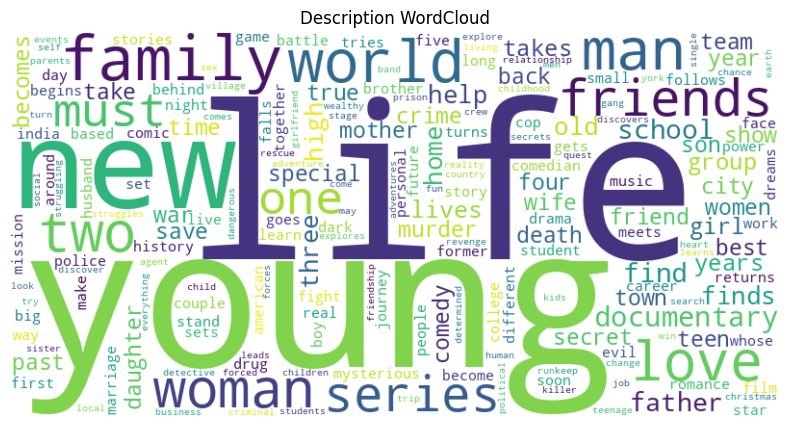

In [ ]:
if 'description' in df.columns:
    text_all = " ".join(df['description'].astype(str).tolist())
    stop = set(stopwords.words('english')) | set(STOPWORDS)
    # basic tokenization and frequency
    tokens = [w.lower() for w in re.findall(r'\b[a-zA-Z]{3,}\b', text_all)]
    tokens = [t for t in tokens if t not in stop]
    freq = Counter(tokens)
    top_words = freq.most_common(30)
    print("Top description words (sample):", top_words[:15])

    # Wordcloud
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop).generate_from_frequencies(freq)
    plt.figure(figsize=(12,5)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.title("Description WordCloud"); plt.show()
else:
    print("No description column for NLP.")

In [ ]:
# 1) Movies vs TV Shows over years (line)
df_plot = df.dropna(subset=['year_added']).copy()
df_plot['year_added'] = df_plot['year_added'].astype(int)
by_year_type = df_plot.groupby(['year_added','type']).size().reset_index(name='count')
fig = px.line(by_year_type, x='year_added', y='count', color='type', title="Titles added per year by Type (interactive)")
fig.show()

# 2) Top genres bar
top_genres = df['primary_genre'].value_counts().head(15).reset_index()
top_genres.columns = ['genre','count']
fig2 = px.bar(top_genres, x='count', y='genre', orientation='h', title="Top primary genres")
fig2.show()

# 3) Top countries (explode)
country_exploded = df.explode('country_list')
top_countries = country_exploded['country_list'].value_counts().head(20).reset_index()
top_countries.columns = ['country','count']
fig3 = px.bar(top_countries, x='count', y='country', orientation='h', title="Top countries by title-count")
fig3.show()



In [ ]:
#Genre time-series analysis (popularity by year) ----------------
top_n = 8
top_genre_list = df['primary_genre'].value_counts().head(top_n).index.tolist()
df_gen_ts = df_plot[df_plot['primary_genre'].isin(top_genre_list)].groupby(['year_added','primary_genre']).size().unstack(fill_value=0)
df_gen_ts = df_gen_ts.reindex(range(int(df_gen_ts.index.min()), int(df_gen_ts.index.max())+1), fill_value=0)
fig = px.area(df_gen_ts, x=df_gen_ts.index, y=df_gen_ts.columns, title=f"Genre composition over years (top {top_n})")
fig.show()


In [ ]:
# Need country ISO codes for choropleth; try mapping using pycountry fallback
!pip install -q pycountry
import pycountry
def country_to_iso(name):
    try:
        c = pycountry.countries.lookup(name)
        return c.alpha_3
    except:
        return None

top_country_counts = country_exploded['country_list'].value_counts().reset_index()
top_country_counts.columns = ['country','count']
top_country_counts['iso3'] = top_country_counts['country'].apply(country_to_iso)
# filter those with iso
chor = top_country_counts.dropna(subset=['iso3']).head(100)
fig = px.choropleth(chor, locations='iso3', color='count', hover_name='country', title='Country contributions (top)')
fig.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 67.5 MB/s eta 0:00:00


In [ ]:
# Features: genre multi-hot + numeric imputed features
mlb = MultiLabelBinarizer()
genre_vectors = mlb.fit_transform(df['genre_list'])
genre_df = pd.DataFrame(genre_vectors, columns=["g_"+re.sub(r'\W+','_',g) for g in mlb.classes_], index=df.index)
feat_df = pd.concat([genre_df.reset_index(drop=True),
                     df[['duration_value_imp','release_year_imp','country_count_imp']].reset_index(drop=True)], axis=1).fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feat_df)
# PCA 2D
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)
df['pca1'] = pc[:,0]; df['pca2'] = pc[:,1]
# KMeans clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels
# profile clusters
for c in range(k):
    sub = df[df['cluster']==c]
    print(f"Cluster {c}: size={len(sub)}, top genres: {sub['primary_genre'].value_counts().head(5).to_dict()}, avg duration: {sub['duration_value_imp'].mean():.1f}")


Cluster 0: size=345, top genres: {'Movie': 323, 'TV Show': 22}, avg duration: 97.6
Cluster 1: size=2387, top genres: {'TV Show': 2387}, avg duration: 1.8
Cluster 2: size=2727, top genres: {'Movie': 2727}, avg duration: 101.0
Cluster 3: size=2330, top genres: {'Movie': 2329, 'TV Show': 1}, avg duration: 96.6


In [ ]:
# PCA scatter (interactive)
fig = px.scatter(df.sample(min(1500, len(df))), x='pca1', y='pca2', color='cluster', hover_data=['title','primary_genre'])
fig.update_layout(title="PCA scatter of content (sampled)")
fig.show()

In [ ]:
# Create a simple vector per title: genre multi-hot + country_count + duration normalized
rec_df = feat_df.copy()
# Normalize numeric
rec_df['duration_norm'] = (rec_df['duration_value_imp'] - rec_df['duration_value_imp'].mean())/ (rec_df['duration_value_imp'].std()+1e-9)
rec_df = rec_df.fillna(0)
# Compute cosine similarity on small sample due to memory
from sklearn.metrics.pairwise import cosine_similarity
sample_size = min(2000, len(rec_df))
sample_idx = np.random.choice(range(len(rec_df)), size=sample_size, replace=False)
S = cosine_similarity(rec_df.iloc[sample_idx], rec_df.iloc[sample_idx])
# function to get top k similar for a given index
def get_similar(title, top_k=5):
    try:
        idx = df[df['title'].str.lower()==title.lower()].index[0]
        if idx not in sample_idx:
            # find nearest in sample by genre overlap
            vec = rec_df.loc[idx].values.reshape(1,-1)
            sims = cosine_similarity(vec, rec_df.iloc[sample_idx])[0]
            top = np.argsort(sims)[-top_k:][::-1]
            sim_idx = [sample_idx[t] for t in top]
        else:
            pos = list(sample_idx).index(idx)
            sims = S[pos]
            top = np.argsort(sims)[-top_k-1:][::-1]  # exclude self later
            sim_idx = [sample_idx[t] for t in top if sample_idx[t]!=idx][:top_k]
        return df.loc[sim_idx][['title','primary_genre','country']].head(top_k)
    except Exception as e:
        return f"Title not found or error: {e}"
# Example usage (replace with any title from your data)
example_title = df['title'].dropna().iloc[0]
print("Example title:", example_title)
print(get_similar(example_title, top_k=5))


Example title: 3%
                   title primary_genre        country
5704  Somebody Feed Phil       TV Show  United States
3488    La casa de papel       TV Show          Spain
380        Alexa & Katie       TV Show  United States
2563                   H       TV Show         France
6407      The Good Place       TV Show  United States


In [ ]:
# Prepare annual counts by type
agg = df_plot.groupby(['year_added','type']).size().reset_index(name='count')
# Pivot for each type
types = agg['type'].unique().tolist()
forecasts = {}
for t in types:
    ts = agg[agg['type']==t][['year_added','count']].rename(columns={'year_added':'ds','count':'y'})
    ts['ds'] = pd.to_datetime(ts['ds'].astype(int).astype(str) + '-01-01')
    if HAS_PROPHET and len(ts) >= 4:
        m = Prophet(yearly_seasonality=False, daily_seasonality=False)
        m.fit(ts)
        future = m.make_future_dataframe(periods=5, freq='Y')
        fcst = m.predict(future)
        preds = fcst[['ds','yhat']].tail(5)
        forecasts[t] = preds
    else:
        # Linear regression fallback on integer years
        if len(ts) >= 3:
            X = np.array([(d.year) for d in ts['ds']]).reshape(-1,1)
            y = ts['y'].values
            from sklearn.linear_model import LinearRegression
            lr = LinearRegression().fit(X,y)
            last_year = int(ts['ds'].dt.year.max())
            future_years = np.array(list(range(last_year+1, last_year+6))).reshape(-1,1)
            preds = lr.predict(future_years)
            fdf = pd.DataFrame({'ds': pd.to_datetime([str(y)+'-01-01' for y in future_years.flatten()]), 'yhat': preds})
            forecasts[t] = fdf
        else:
            forecasts[t] = None
            # Print example forecast (Movie)
for t, f in forecasts.items():
    print("Forecast for:", t)
    if f is None:
        print("Not enough data")
    else:
        display(f.head())



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16ez89yj/yycqqtba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp16ez89yj/_ahqb6ps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46464', 'data', 'file=/tmp/tmp16ez89yj/yycqqtba.json', 'init=/tmp/tmp16ez89yj/_ahqb6ps.json', 'output', 'file=/tmp/tmp16ez89yj/prophet_model3u9_ihk4/prophet_model-20251005040938.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:09:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:09:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekl

Forecast for: Dramas, Independent Movies, Thrillers


ds       yhat
6  2020-12-31   7.783527
7  2021-12-31   8.451453
8  2022-12-31   9.119380
9  2023-12-31   9.787306
10 2024-12-31  10.457063

Forecast for: Stand-Up Comedy & Talk Shows


ds      yhat
4 2020-12-31  1.716246
5 2021-12-31  1.757526
6 2022-12-31  1.798806
7 2023-12-31  1.840086
8 2024-12-31  1.881479

Forecast for: Dramas, International Movies


ds       yhat
9  2021-12-31  67.339714
10 2022-12-31  72.837340
11 2023-12-31  78.334966
12 2024-12-31  83.847655
13 2025-12-31  89.345281

Forecast for: Horror Movies


ds       yhat
7  2021-12-31   9.335290
8  2022-12-31   9.973565
9  2023-12-31  10.611841
10 2024-12-31  11.251865
11 2025-12-31  11.890141

Forecast for: Cult Movies, Horror Movies


ds      yhat
0 2021-01-01  1.538462
1 2022-01-01  1.582418
2 2023-01-01  1.626374
3 2024-01-01  1.670330
4 2025-01-01  1.714286

Forecast for: Children & Family Movies, Dramas, Faith & Spirituality


ds      yhat
0 2021-01-01  2.260274
1 2022-01-01  2.397260
2 2023-01-01  2.534247
3 2024-01-01  2.671233
4 2025-01-01  2.808219

Forecast for: Dramas


ds       yhat
8  2021-12-31  23.982936
9  2022-12-31  25.870143
10 2023-12-31  27.757349
11 2024-12-31  29.649726
12 2025-12-31  31.536932

Forecast for: Dramas, Sports Movies


ds      yhat
4 2020-12-31  5.920431
5 2021-12-31  6.338362
6 2022-12-31  6.756293
7 2023-12-31  7.174224
8 2024-12-31  7.593301

Forecast for: Dramas, Thrillers


ds       yhat
7  2021-12-31  15.802478
8  2022-12-31  17.105239
9  2023-12-31  18.408000
10 2024-12-31  19.714331
11 2025-12-31  21.017092

Forecast for: Children & Family Movies, Comedies


ds       yhat
9  2021-12-31  41.401026
10 2022-12-31  45.827935
11 2023-12-31  50.254844
12 2024-12-31  54.693882
13 2025-12-31  59.120791

Forecast for: Comedies


ds       yhat
8  2021-12-31  22.516190
9  2022-12-31  24.706991
10 2023-12-31  26.897793
11 2024-12-31  29.094596
12 2025-12-31  31.285398

Forecast for: Documentaries


ds       yhat
9  2021-12-31  62.194692
10 2022-12-31  67.116594
11 2023-12-31  72.038496
12 2024-12-31  76.973883
13 2025-12-31  81.895786

Forecast for: Children & Family Movies, Comedies, Music & Musicals


ds      yhat
5 2020-12-31  3.503534
6 2021-12-31  3.865619
7 2022-12-31  4.227705
8 2023-12-31  4.589791
9 2024-12-31  4.952869

Forecast for: Children & Family Movies, Documentaries, Sports Movies
Not enough data
Forecast for: Crime TV Shows, International TV Shows, TV Dramas


ds       yhat
6  2020-12-31  35.093119
7  2021-12-31  39.638250
8  2022-12-31  44.183381
9  2023-12-31  48.728513
10 2024-12-31  53.286096

Forecast for: Crime TV Shows, TV Dramas, TV Thrillers


ds      yhat
4 2020-12-31  2.817192
5 2021-12-31  3.083610
6 2022-12-31  3.350028
7 2023-12-31  3.616446
8 2024-12-31  3.883593

Forecast for: Docuseries, Stand-Up Comedy & Talk Shows
Not enough data
Forecast for: Stand-Up Comedy


ds       yhat
9  2021-12-31  59.191751
10 2022-12-31  63.892678
11 2023-12-31  68.593604
12 2024-12-31  73.307410
13 2025-12-31  78.008336

Forecast for: TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy


ds  yhat
4 2019-12-31   1.0
5 2020-12-31   1.0
6 2021-12-31   1.0
7 2022-12-31   1.0
8 2023-12-31   1.0

Forecast for: TV Dramas, Teen TV Shows


ds      yhat
0 2021-01-01  2.348837
1 2022-01-01  2.534884
2 2023-01-01  2.720930
3 2024-01-01  2.906977
4 2025-01-01  3.093023

Forecast for: Action & Adventure, Sci-Fi & Fantasy


ds       yhat
6  2020-12-31  19.906645
7  2021-12-31  22.971025
8  2022-12-31  26.035405
9  2023-12-31  29.099786
10 2024-12-31  32.172561

Forecast for: Children & Family Movies


ds       yhat
8  2021-12-31  41.749671
9  2022-12-31  46.087335
10 2023-12-31  50.425000
11 2024-12-31  54.774548
12 2025-12-31  59.112213

Forecast for: Children & Family Movies, Sci-Fi & Fantasy


ds      yhat
5 2019-12-31  1.701881
6 2020-12-31  1.796676
7 2021-12-31  1.891213
8 2022-12-31  1.985749
9 2023-12-31  2.080285

Forecast for: Classic & Cult TV, Kids' TV, TV Comedies
Not enough data
Forecast for: Crime TV Shows, TV Comedies, TV Dramas


ds      yhat
5 2020-12-31  3.102815
6 2021-12-31  3.445619
7 2022-12-31  3.788422
8 2023-12-31  4.131226
9 2024-12-31  4.474969

Forecast for: Documentaries, International Movies


ds       yhat
8  2021-12-31  29.504877
9  2022-12-31  31.285683
10 2023-12-31  33.066489
11 2024-12-31  34.852174
12 2025-12-31  36.632980

Forecast for: Documentaries, Sports Movies


ds       yhat
7  2020-12-31  15.422477
8  2021-12-31  17.239650
9  2022-12-31  19.056823
10 2023-12-31  20.873996
11 2024-12-31  22.696147

Forecast for: Kids' TV


ds       yhat
8  2021-12-31  42.180096
9  2022-12-31  45.883892
10 2023-12-31  49.587688
11 2024-12-31  53.301631
12 2025-12-31  57.005427

Forecast for: Kids' TV, TV Thrillers


ds  yhat
5 2021-12-31   1.0
6 2022-12-31   1.0
7 2023-12-31   1.0
8 2024-12-31   1.0
9 2025-12-31   1.0

Forecast for: Movies


ds       yhat
7  2020-12-31  12.406066
8  2021-12-31  13.509392
9  2022-12-31  14.612719
10 2023-12-31  15.716045
11 2024-12-31  16.822395

Forecast for: TV Comedies, TV Dramas


ds       yhat
6  2020-12-31  12.214373
7  2021-12-31  14.025821
8  2022-12-31  15.837270
9  2023-12-31  17.648718
10 2024-12-31  19.465130

Forecast for: TV Dramas


ds       yhat
7  2020-12-31  11.002322
8  2021-12-31  12.537234
9  2022-12-31  14.072145
10 2023-12-31  15.607057
11 2024-12-31  17.146175

Forecast for: Action & Adventure, Comedies


ds       yhat
6  2021-12-31  11.860961
7  2022-12-31  13.254817
8  2023-12-31  14.648673
9  2024-12-31  16.046348
10 2025-12-31  17.440204

Forecast for: Action & Adventure, Dramas, International Movies


ds       yhat
7  2021-12-31  21.101545
8  2022-12-31  22.233958
9  2023-12-31  23.366372
10 2024-12-31  24.501888
11 2025-12-31  25.634301

Forecast for: British TV Shows, Docuseries, International TV Shows


ds       yhat
6  2020-12-31   7.922421
7  2021-12-31   8.805466
8  2022-12-31   9.688510
9  2023-12-31  10.571554
10 2024-12-31  11.457018

Forecast for: British TV Shows, Docuseries, Science & Nature TV


ds      yhat
5 2019-12-31  5.034312
6 2020-12-31  5.040654
7 2021-12-31  5.046980
8 2022-12-31  5.053305
9 2023-12-31  5.059630

Forecast for: British TV Shows, Kids' TV, TV Comedies


ds      yhat
0 2021-01-01  3.833333
1 2022-01-01  4.333333
2 2023-01-01  4.833333
3 2024-01-01  5.333333
4 2025-01-01  5.833333

Forecast for: Children & Family Movies, Comedies, Sports Movies


ds  yhat
0 2022-01-01   1.0
1 2023-01-01   1.0
2 2024-01-01   1.0
3 2025-01-01   1.0
4 2026-01-01   1.0

Forecast for: Children & Family Movies, Music & Musicals


ds      yhat
5 2020-12-31  4.460749
6 2021-12-31  4.866810
7 2022-12-31  5.272872
8 2023-12-31  5.678934
9 2024-12-31  6.086108

Forecast for: Classic & Cult TV, TV Horror, TV Mysteries
Not enough data
Forecast for: Comedies, Dramas, Independent Movies


ds       yhat
7  2021-12-31  24.663694
8  2022-12-31  27.187398
9  2023-12-31  29.711102
10 2024-12-31  32.241720
11 2025-12-31  34.765424

Forecast for: Comedies, Dramas, International Movies


ds       yhat
7  2021-12-31  59.127785
8  2022-12-31  65.233124
9  2023-12-31  71.338464
10 2024-12-31  77.460530
11 2025-12-31  83.565870

Forecast for: Comedies, Dramas, LGBTQ Movies


ds      yhat
0 2021-01-01  1.547619
1 2022-01-01  1.619048
2 2023-01-01  1.690476
3 2024-01-01  1.761905
4 2025-01-01  1.833333

Forecast for: Comedies, Independent Movies


ds      yhat
5 2020-12-31  5.539478
6 2021-12-31  5.840668
7 2022-12-31  6.141858
8 2023-12-31  6.443049
9 2024-12-31  6.745064

Forecast for: Comedies, International Movies


ds       yhat
7  2021-12-31  38.879172
8  2022-12-31  42.853156
9  2023-12-31  46.827140
10 2024-12-31  50.812011
11 2025-12-31  54.785995

Forecast for: Comedies, Music & Musicals


ds      yhat
0 2021-01-01  1.421053
1 2022-01-01  1.447368
2 2023-01-01  1.473684
3 2024-01-01  1.500000
4 2025-01-01  1.526316

Forecast for: Documentaries, International Movies, Music & Musicals


ds      yhat
6  2021-12-31  6.488436
7  2022-12-31  6.803085
8  2023-12-31  7.117735
9  2024-12-31  7.433247
10 2025-12-31  7.747896

Forecast for: Documentaries, International Movies, Sports Movies


ds      yhat
7  2021-12-31  7.278905
8  2022-12-31  7.744510
9  2023-12-31  8.210115
10 2024-12-31  8.676996
11 2025-12-31  9.142601

Forecast for: Documentaries, Music & Musicals


ds       yhat
6  2020-12-31  24.642020
7  2021-12-31  28.205973
8  2022-12-31  31.769925
9  2023-12-31  35.333877
10 2024-12-31  38.907594

Forecast for: Documentaries, Stand-Up Comedy
Not enough data
Forecast for: Dramas, Independent Movies


ds       yhat
7  2021-12-31  20.543219
8  2022-12-31  22.322364
9  2023-12-31  24.101508
10 2024-12-31  25.885526
11 2025-12-31  27.664671

Forecast for: Dramas, Independent Movies, Romantic Movies


ds      yhat
6  2020-12-31  5.924369
7  2021-12-31  6.664899
8  2022-12-31  7.405430
9  2023-12-31  8.145961
10 2024-12-31  8.888520

Forecast for: Dramas, Independent Movies, Sci-Fi & Fantasy


ds      yhat
4 2020-12-31  1.172084
5 2021-12-31  1.071468
6 2022-12-31  0.970852
7 2023-12-31  0.870236
8 2024-12-31  0.769344

Forecast for: Dramas, International Movies, Thrillers


ds       yhat
6  2020-12-31  40.262043
7  2021-12-31  46.566659
8  2022-12-31  52.871276
9  2023-12-31  59.175892
10 2024-12-31  65.497781

Forecast for: Horror Movies, Independent Movies, Thrillers


ds      yhat
6  2020-12-31  4.463614
7  2021-12-31  4.976829
8  2022-12-31  5.490043
9  2023-12-31  6.003258
10 2024-12-31  6.517878

Forecast for: International TV Shows, TV Dramas


ds       yhat
6  2020-12-31  35.567754
7  2021-12-31  40.441350
8  2022-12-31  45.314946
9  2023-12-31  50.188542
10 2024-12-31  55.075490

Forecast for: Kids' TV, TV Action & Adventure, TV Sci-Fi & Fantasy


ds      yhat
4 2020-12-31  4.848855
5 2021-12-31  5.631959
6 2022-12-31  6.415062
7 2023-12-31  7.198166
8 2024-12-31  7.983415

Forecast for: Kids' TV, TV Comedies


ds       yhat
7  2021-12-31  21.969598
8  2022-12-31  24.254765
9  2023-12-31  26.539931
10 2024-12-31  28.831359
11 2025-12-31  31.116526

Forecast for: Romantic TV Shows, TV Dramas, TV Sci-Fi & Fantasy
Not enough data
Forecast for: TV Action & Adventure, TV Dramas


ds  yhat
5 2021-12-31   1.0
6 2022-12-31   1.0
7 2023-12-31   1.0
8 2024-12-31   1.0
9 2025-12-31   1.0

Forecast for: TV Comedies


ds       yhat
6  2020-12-31  24.263484
7  2021-12-31  28.289187
8  2022-12-31  32.314890
9  2023-12-31  36.340594
10 2024-12-31  40.377326

Forecast for: TV Comedies, TV Dramas, Teen TV Shows


ds      yhat
5 2020-12-31  2.149511
6 2021-12-31  2.370277
7 2022-12-31  2.591042
8 2023-12-31  2.811808
9 2024-12-31  3.033178

Forecast for: TV Horror, TV Mysteries, TV Thrillers
Not enough data
Forecast for: Action & Adventure


ds       yhat
6  2021-12-31  28.320094
7  2022-12-31  31.699274
8  2023-12-31  35.078455
9  2024-12-31  38.466893
10 2025-12-31  41.846073

Forecast for: Action & Adventure, Anime Features, International Movies


ds      yhat
5 2020-12-31  4.121838
6 2021-12-31  3.631272
7 2022-12-31  3.140706
8 2023-12-31  2.650140
9 2024-12-31  2.158230

Forecast for: Action & Adventure, Anime Features, Sci-Fi & Fantasy


ds      yhat
4 2019-12-31  0.502433
5 2020-12-31  0.202466
6 2021-12-31 -0.096682
7 2022-12-31 -0.395831
8 2023-12-31 -0.694979

Forecast for: Action & Adventure, Comedies, Independent Movies


ds      yhat
4 2020-12-31  2.142469
5 2021-12-31  2.285756
6 2022-12-31  2.429043
7 2023-12-31  2.572329
8 2024-12-31  2.716009

Forecast for: Action & Adventure, Comedies, International Movies


ds       yhat
6  2021-12-31  11.877656
7  2022-12-31  12.083403
8  2023-12-31  12.289150
9  2024-12-31  12.495461
10 2025-12-31  12.701209

Forecast for: Action & Adventure, Horror Movies, International Movies


ds      yhat
0 2020-01-01  2.285714
1 2021-01-01  2.642857
2 2022-01-01  3.000000
3 2023-01-01  3.357143
4 2024-01-01  3.714286

Forecast for: Action & Adventure, International Movies


ds       yhat
5 2020-12-31  27.854348
6 2021-12-31  31.265450
7 2022-12-31  34.676552
8 2023-12-31  38.087654
9 2024-12-31  41.508102

Forecast for: Action & Adventure, Romantic Movies
Not enough data
Forecast for: Anime Features, Children & Family Movies


ds      yhat
4 2020-12-31  3.391674
5 2021-12-31  3.989132
6 2022-12-31  4.586589
7 2023-12-31  5.184047
8 2024-12-31  5.783142

Forecast for: Anime Series


ds      yhat
0 2021-01-01  4.923077
1 2022-01-01  5.769231
2 2023-01-01  6.615385
3 2024-01-01  7.461538
4 2025-01-01  8.307692

Forecast for: Anime Series, Crime TV Shows
Not enough data
Forecast for: Anime Series, Crime TV Shows, International TV Shows


ds      yhat
5 2020-12-31  3.299625
6 2021-12-31  3.799334
7 2022-12-31  4.299044
8 2023-12-31  4.798754
9 2024-12-31  5.299833

Forecast for: Anime Series, International TV Shows


ds       yhat
5 2020-12-31  33.006015
6 2021-12-31  38.997478
7 2022-12-31  44.988940
8 2023-12-31  50.980402
9 2024-12-31  56.988279

Forecast for: Anime Series, International TV Shows, Romantic TV Shows


ds      yhat
4 2020-12-31  1.829170
5 2021-12-31  1.858327
6 2022-12-31  1.887485
7 2023-12-31  1.916642
8 2024-12-31  1.945880

Forecast for: Anime Series, Kids' TV


ds       yhat
5 2020-12-31   6.988614
6 2021-12-31   7.984883
7 2022-12-31   8.981153
8 2023-12-31   9.977423
9 2024-12-31  10.976422

Forecast for: British TV Shows, Crime TV Shows, Docuseries


ds      yhat
6  2021-12-31  2.795265
7  2022-12-31  2.738101
8  2023-12-31  2.680937
9  2024-12-31  2.623616
10 2025-12-31  2.566452

Forecast for: British TV Shows, Crime TV Shows, International TV Shows


ds      yhat
5 2020-12-31  4.894128
6 2021-12-31  5.191375
7 2022-12-31  5.488621
8 2023-12-31  5.785868
9 2024-12-31  6.083928

Forecast for: British TV Shows, Docuseries


ds      yhat
5 2020-12-31  3.282907
6 2021-12-31  3.577022
7 2022-12-31  3.871137
8 2023-12-31  4.165252
9 2024-12-31  4.460173

Forecast for: British TV Shows, Docuseries, Reality TV
Not enough data
Forecast for: British TV Shows, International TV Shows, TV Action & Adventure


ds      yhat
0 2021-01-01  2.083333
1 2022-01-01  2.333333
2 2023-01-01  2.583333
3 2024-01-01  2.833333
4 2025-01-01  3.083333

Forecast for: British TV Shows, International TV Shows, TV Comedies


ds       yhat
4 2020-12-31   6.647869
5 2021-12-31   7.701710
6 2022-12-31   8.755550
7 2023-12-31   9.809391
8 2024-12-31  10.866118

Forecast for: British TV Shows, Kids' TV


ds       yhat
5 2020-12-31   7.890089
6 2021-12-31   9.387434
7 2022-12-31  10.884778
8 2023-12-31  12.382123
9 2024-12-31  13.883569

Forecast for: British TV Shows, TV Comedies


ds      yhat
5 2020-12-31  1.715815
6 2021-12-31  1.419900
7 2022-12-31  1.123986
8 2023-12-31  0.828071
9 2024-12-31  0.531345

Forecast for: British TV Shows, TV Dramas, TV Sci-Fi & Fantasy
Not enough data
Forecast for: British TV Shows, TV Horror, TV Thrillers
Not enough data
Forecast for: Children & Family Movies, Comedies, Cult Movies
Not enough data
Forecast for: Children & Family Movies, Dramas, Sports Movies


ds      yhat
5 2021-12-31  1.275040
6 2022-12-31  1.128530
7 2023-12-31  0.982020
8 2024-12-31  0.835109
9 2025-12-31  0.688599

Forecast for: Classic & Cult TV, TV Action & Adventure, TV Horror
Not enough data
Forecast for: Classic Movies, Dramas


ds      yhat
5 2021-12-31  2.002335
6 2022-12-31  2.003383
7 2023-12-31  2.004430
8 2024-12-31  2.005480
9 2025-12-31  2.006528

Forecast for: Comedies, Dramas, Romantic Movies


ds      yhat
6  2021-12-31  4.531769
7  2022-12-31  5.158145
8  2023-12-31  5.784522
9  2024-12-31  6.412615
10 2025-12-31  7.038992

Forecast for: Comedies, Horror Movies


ds      yhat
4 2020-12-31  4.842328
5 2021-12-31  5.539897
6 2022-12-31  6.237467
7 2023-12-31  6.935037
8 2024-12-31  7.634518

Forecast for: Comedies, Horror Movies, Independent Movies


ds      yhat
0 2020-01-01  2.500000
1 2021-01-01  2.857143
2 2022-01-01  3.214286
3 2023-01-01  3.571429
4 2024-01-01  3.928571

Forecast for: Comedies, Independent Movies, International Movies


ds      yhat
5 2020-12-31  3.418554
6 2021-12-31  3.425541
7 2022-12-31  3.432527
8 2023-12-31  3.439513
9 2024-12-31  3.446518

Forecast for: Comedies, International Movies, Music & Musicals


ds       yhat
6  2021-12-31  10.730583
7  2022-12-31  11.274096
8  2023-12-31  11.817608
9  2024-12-31  12.362609
10 2025-12-31  12.906122

Forecast for: Comedies, International Movies, Romantic Movies


ds       yhat
6  2021-12-31  29.045189
7  2022-12-31  30.729323
8  2023-12-31  32.413456
9  2024-12-31  34.102204
10 2025-12-31  35.786337

Forecast for: Comedies, International Movies, Sports Movies


ds      yhat
4 2019-12-31  0.503189
5 2020-12-31  0.103189
6 2021-12-31 -0.295719
7 2022-12-31 -0.694627
8 2023-12-31 -1.093535

Forecast for: Comedies, LGBTQ Movies
Not enough data
Forecast for: Crime TV Shows, Docuseries


ds       yhat
6  2021-12-31  11.201968
7  2022-12-31  12.258301
8  2023-12-31  13.314635
9  2024-12-31  14.373862
10 2025-12-31  15.430196

Forecast for: Crime TV Shows, Docuseries, Science & Nature TV
Not enough data
Forecast for: Crime TV Shows, International TV Shows, Romantic TV Shows


ds      yhat
0 2020-01-01  3.714286
1 2021-01-01  4.357143
2 2022-01-01  5.000000
3 2023-01-01  5.642857
4 2024-01-01  6.285714

Forecast for: Crime TV Shows, International TV Shows, Spanish-Language TV Shows


ds       yhat
5 2020-12-31  24.696703
6 2021-12-31  29.191132
7 2022-12-31  33.685561
8 2023-12-31  38.179990
9 2024-12-31  42.686732

Forecast for: Crime TV Shows, International TV Shows, TV Action & Adventure


ds      yhat
6  2021-12-31  2.007219
7  2022-12-31  1.866709
8  2023-12-31  1.726199
9  2024-12-31  1.585304
10 2025-12-31  1.444794

Forecast for: Crime TV Shows, Romantic TV Shows, TV Dramas
Not enough data
Forecast for: Crime TV Shows, TV Action & Adventure


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Crime TV Shows, TV Action & Adventure, TV Dramas


ds      yhat
5 2020-12-31  3.698737
6 2021-12-31  4.198381
7 2022-12-31  4.698026
8 2023-12-31  5.197670
9 2024-12-31  5.698684

Forecast for: Crime TV Shows, TV Comedies
Not enough data
Forecast for: Crime TV Shows, TV Dramas, TV Mysteries


ds       yhat
5 2020-12-31   6.396276
6 2021-12-31   7.394916
7 2022-12-31   8.393556
8 2023-12-31   9.392196
9 2024-12-31  10.393572

Forecast for: Cult Movies, Dramas, Thrillers
Not enough data
Forecast for: Documentaries, Faith & Spirituality, Music & Musicals
Not enough data
Forecast for: Docuseries


ds       yhat
6  2021-12-31  14.862603
7  2022-12-31  15.634620
8  2023-12-31  16.406637
9  2024-12-31  17.180769
10 2025-12-31  17.952786

Forecast for: Docuseries, International TV Shows


ds      yhat
6  2021-12-31  5.002143
7  2022-12-31  5.145778
8  2023-12-31  5.289414
9  2024-12-31  5.433443
10 2025-12-31  5.577078

Forecast for: Docuseries, International TV Shows, Reality TV


ds      yhat
4 2020-12-31  2.084750
5 2021-12-31  2.341558
6 2022-12-31  2.598366
7 2023-12-31  2.855174
8 2024-12-31  3.112686

Forecast for: Docuseries, International TV Shows, Science & Nature TV


ds      yhat
5 2020-12-31  1.113488
6 2021-12-31  0.618089
7 2022-12-31  0.122689
8 2023-12-31 -0.372711
9 2024-12-31 -0.869468

Forecast for: Docuseries, Science & Nature TV


ds       yhat
6  2021-12-31   8.055693
7  2022-12-31   8.738643
8  2023-12-31   9.421593
9  2024-12-31  10.106415
10 2025-12-31  10.789365

Forecast for: Dramas, Independent Movies, International Movies


ds       yhat
6  2021-12-31  30.424917
7  2022-12-31  28.884740
8  2023-12-31  27.344563
9  2024-12-31  25.800166
10 2025-12-31  24.259989

Forecast for: Dramas, International Movies, LGBTQ Movies


ds      yhat
5 2021-12-31  3.105926
6 2022-12-31  3.388706
7 2023-12-31  3.671487
8 2024-12-31  3.955042
9 2025-12-31  4.237823

Forecast for: Dramas, International Movies, Romantic Movies


ds        yhat
5 2020-12-31   66.879877
6 2021-12-31   78.971058
7 2022-12-31   91.062239
8 2023-12-31  103.153420
9 2024-12-31  115.277728

Forecast for: Dramas, International Movies, Sports Movies


ds       yhat
5 2020-12-31   9.193863
6 2021-12-31  10.591684
7 2022-12-31  11.989504
8 2023-12-31  13.387324
9 2024-12-31  14.788974

Forecast for: Dramas, Music & Musicals


ds      yhat
0 2021-01-01  2.384615
1 2022-01-01  2.653846
2 2023-01-01  2.923077
3 2024-01-01  3.192308
4 2025-01-01  3.461538

Forecast for: Horror Movies, International Movies, Thrillers


ds       yhat
5 2020-12-31  14.099699
6 2021-12-31  16.397647
7 2022-12-31  18.695596
8 2023-12-31  20.993544
9 2024-12-31  23.297788

Forecast for: Horror Movies, Thrillers


ds       yhat
6  2021-12-31  10.525684
7  2022-12-31  11.153674
8  2023-12-31  11.781664
9  2024-12-31  12.411375
10 2025-12-31  13.039365

Forecast for: International Movies, Sci-Fi & Fantasy, Thrillers


ds      yhat
4 2020-12-31  1.657534
5 2021-12-31  1.460442
6 2022-12-31  1.263351
7 2023-12-31  1.066260
8 2024-12-31  0.868629

Forecast for: International Movies, Thrillers


ds       yhat
6  2021-12-31  13.692833
7  2022-12-31  14.801239
8  2023-12-31  15.909646
9  2024-12-31  17.021089
10 2025-12-31  18.129496

Forecast for: International TV Shows, Korean TV Shows, Romantic TV Shows


ds       yhat
5 2020-12-31  20.967527
6 2021-12-31  23.586474
7 2022-12-31  26.205422
8 2023-12-31  28.824370
9 2024-12-31  31.450493

Forecast for: International TV Shows, Korean TV Shows, TV Dramas


ds      yhat
5 2020-12-31  3.005521
6 2021-12-31  2.808956
7 2022-12-31  2.612391
8 2023-12-31  2.415827
9 2024-12-31  2.218723

Forecast for: International TV Shows, Reality TV


ds       yhat
5 2020-12-31  15.884027
6 2021-12-31  18.977851
7 2022-12-31  22.071675
8 2023-12-31  25.165500
9 2024-12-31  28.267801

Forecast for: International TV Shows, Romantic TV Shows, Spanish-Language TV Shows


ds       yhat
5 2020-12-31   6.477878
6 2021-12-31   7.370123
7 2022-12-31   8.262367
8 2023-12-31   9.154611
9 2024-12-31  10.049300

Forecast for: International TV Shows, Romantic TV Shows, TV Comedies


ds       yhat
5 2020-12-31  11.379998
6 2021-12-31   9.905245
7 2022-12-31   8.430493
8 2023-12-31   6.955740
9 2024-12-31   5.476948

Forecast for: International TV Shows, Romantic TV Shows, TV Dramas


ds       yhat
5 2020-12-31  19.889640
6 2021-12-31  20.793042
7 2022-12-31  21.696444
8 2023-12-31  22.599846
9 2024-12-31  23.505723

Forecast for: International TV Shows, Spanish-Language TV Shows, TV Dramas


ds      yhat
6  2021-12-31  4.001749
7  2022-12-31  4.145113
8  2023-12-31  4.288477
9  2024-12-31  4.432234
10 2025-12-31  4.575597

Forecast for: International TV Shows, TV Action & Adventure, TV Sci-Fi & Fantasy


ds      yhat
0 2020-01-01  1.142857
1 2021-01-01  1.071429
2 2022-01-01  1.000000
3 2023-01-01  0.928571
4 2024-01-01  0.857143

Forecast for: International TV Shows, TV Comedies


ds       yhat
5 2020-12-31   9.201328
6 2021-12-31  10.399880
7 2022-12-31  11.598432
8 2023-12-31  12.796984
9 2024-12-31  13.998820

Forecast for: International TV Shows, TV Comedies, TV Dramas


ds       yhat
5 2020-12-31  12.285993
6 2021-12-31  14.181372
7 2022-12-31  16.076751
8 2023-12-31  17.972130
9 2024-12-31  19.872702

Forecast for: International TV Shows, TV Dramas, TV Horror


ds       yhat
5 2020-12-31   6.596242
6 2021-12-31   7.794764
7 2022-12-31   8.993286
8 2023-12-31  10.191808
9 2024-12-31  11.393614

Forecast for: International TV Shows, TV Dramas, TV Mysteries


ds       yhat
5 2020-12-31  10.888141
6 2021-12-31  12.983926
7 2022-12-31  15.079710
8 2023-12-31  17.175495
9 2024-12-31  19.277021

Forecast for: International TV Shows, TV Dramas, TV Thrillers


ds      yhat
5 2020-12-31  2.400118
6 2021-12-31  2.600268
7 2022-12-31  2.800418
8 2023-12-31  3.000568
9 2024-12-31  3.201266

Forecast for: International TV Shows, TV Dramas, Teen TV Shows


ds      yhat
5 2020-12-31  5.094492
6 2021-12-31  5.992974
7 2022-12-31  6.891456
8 2023-12-31  7.789938
9 2024-12-31  8.690882

Forecast for: Kids' TV, Korean TV Shows, TV Comedies
Not enough data
Forecast for: Kids' TV, TV Comedies, TV Dramas


ds      yhat
0 2021-01-01  1.846154
1 2022-01-01  2.038462
2 2023-01-01  2.230769
3 2024-01-01  2.423077
4 2025-01-01  2.615385

Forecast for: Music & Musicals


ds      yhat
4 2020-12-31  5.276197
5 2021-12-31  6.130482
6 2022-12-31  6.984767
7 2023-12-31  7.839051
8 2024-12-31  8.695677

Forecast for: Music & Musicals, Stand-Up Comedy
Not enough data
Forecast for: Reality TV


ds       yhat
6  2021-12-31  25.656151
7  2022-12-31  29.035674
8  2023-12-31  32.415197
9  2024-12-31  35.803979
10 2025-12-31  39.183502

Forecast for: Reality TV, Teen TV Shows
Not enough data
Forecast for: Romantic TV Shows, TV Comedies, TV Dramas


ds      yhat
5 2020-12-31  4.594063
6 2021-12-31  5.391962
7 2022-12-31  6.189860
8 2023-12-31  6.987759
9 2024-12-31  7.787843

Forecast for: Stand-Up Comedy & Talk Shows, TV Comedies


ds      yhat
6  2021-12-31  3.952178
7  2022-12-31  3.840905
8  2023-12-31  3.729632
9  2024-12-31  3.618055
10 2025-12-31  3.506782

Forecast for: TV Action & Adventure, TV Comedies
Not enough data
Forecast for: TV Dramas, TV Horror, TV Mysteries


ds      yhat
4 2020-12-31  2.028276
5 2021-12-31  2.114109
6 2022-12-31  2.199943
7 2023-12-31  2.285777
8 2024-12-31  2.371846

Forecast for: TV Dramas, TV Thrillers


ds      yhat
4 2020-12-31  0.543983
5 2021-12-31  0.287364
6 2022-12-31  0.030744
7 2023-12-31 -0.225875
8 2024-12-31 -0.483197

Forecast for: TV Shows


ds      yhat
5 2020-12-31  2.401353
6 2021-12-31  2.401965
7 2022-12-31  2.402576
8 2023-12-31  2.403188
9 2024-12-31  2.403801

Forecast for: Thrillers


ds       yhat
6  2021-12-31  11.441211
7  2022-12-31  12.379702
8  2023-12-31  13.318192
9  2024-12-31  14.259254
10 2025-12-31  15.197745

Forecast for: Action & Adventure, Anime Features, Horror Movies
Not enough data
Forecast for: Action & Adventure, Children & Family Movies, Comedies


ds      yhat
0 2021-01-01  2.000000
1 2022-01-01  2.285714
2 2023-01-01  2.571429
3 2024-01-01  2.857143
4 2025-01-01  3.142857

Forecast for: Action & Adventure, Comedies, Dramas


ds       yhat
4 2020-12-31   9.502318
5 2021-12-31  10.903122
6 2022-12-31  12.303925
7 2023-12-31  13.704729
8 2024-12-31  15.109371

Forecast for: Action & Adventure, Comedies, Music & Musicals
Not enough data
Forecast for: Action & Adventure, Cult Movies, Dramas
Not enough data
Forecast for: Action & Adventure, Cult Movies, International Movies


ds      yhat
0 2020-01-01  1.333333
1 2021-01-01  1.333333
2 2022-01-01  1.333333
3 2023-01-01  1.333333
4 2024-01-01  1.333333

Forecast for: Action & Adventure, Documentaries, Sports Movies
Not enough data
Forecast for: Action & Adventure, Dramas, Independent Movies


ds      yhat
5 2021-12-31  3.096898
6 2022-12-31  3.396145
7 2023-12-31  3.695393
8 2024-12-31  3.995460
9 2025-12-31  4.294708

Forecast for: Action & Adventure, Independent Movies


ds      yhat
4 2020-12-31  0.001453
5 2021-12-31 -0.697858
6 2022-12-31 -1.397169
7 2023-12-31 -2.096480
8 2024-12-31 -2.797707

Forecast for: Action & Adventure, Independent Movies, Sci-Fi & Fantasy


ds      yhat
0 2020-01-01  0.666667
1 2021-01-01  0.166667
2 2022-01-01 -0.333333
3 2023-01-01 -0.833333
4 2024-01-01 -1.333333

Forecast for: Action & Adventure, International Movies, Music & Musicals


ds      yhat
0 2020-01-01  3.333333
1 2021-01-01  3.333333
2 2022-01-01  3.333333
3 2023-01-01  3.333333
4 2024-01-01  3.333333

Forecast for: Action & Adventure, International Movies, Romantic Movies


ds      yhat
4 2020-12-31  2.996916
5 2021-12-31  3.595758
6 2022-12-31  4.194600
7 2023-12-31  4.793442
8 2024-12-31  5.393925

Forecast for: Action & Adventure, International Movies, Sci-Fi & Fantasy


ds      yhat
4 2020-12-31  2.505818
5 2021-12-31  1.908736
6 2022-12-31  1.311654
7 2023-12-31  0.714572
8 2024-12-31  0.115854

Forecast for: Action & Adventure, International Movies, Thrillers
Not enough data
Forecast for: Action & Adventure, Thrillers
Not enough data
Forecast for: Anime Features
Not enough data
Forecast for: Anime Series, International TV Shows, Teen TV Shows


ds      yhat
4 2021-12-31  1.696680
5 2022-12-31  1.585379
6 2023-12-31  1.474078
7 2024-12-31  1.362472
8 2025-12-31  1.251171

Forecast for: Anime Series, Romantic TV Shows, Teen TV Shows


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: British TV Shows, Classic & Cult TV, International TV Shows
Not enough data
Forecast for: British TV Shows, Classic & Cult TV, TV Comedies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: British TV Shows, Crime TV Shows, TV Dramas
Not enough data
Forecast for: British TV Shows, International TV Shows, Romantic TV Shows
Not enough data
Forecast for: British TV Shows, International TV Shows, TV Dramas


ds       yhat
4 2020-12-31   5.494128
5 2021-12-31   6.691852
6 2022-12-31   7.889576
7 2023-12-31   9.087300
8 2024-12-31  10.288305

Forecast for: British TV Shows, Romantic TV Shows, TV Dramas
Not enough data
Forecast for: Children & Family Movies, Documentaries


ds      yhat
0 2021-01-01  3.000000
1 2022-01-01  3.285714
2 2023-01-01  3.571429
3 2024-01-01  3.857143
4 2025-01-01  4.142857

Forecast for: Children & Family Movies, Documentaries, International Movies
Not enough data
Forecast for: Children & Family Movies, Dramas


ds       yhat
4 2020-12-31  10.491037
5 2021-12-31  12.188026
6 2022-12-31  13.885015
7 2023-12-31  15.582004
8 2024-12-31  17.283642

Forecast for: Children & Family Movies, Dramas, Music & Musicals
Not enough data
Forecast for: Children & Family Movies, Dramas, Romantic Movies


ds      yhat
4 2020-12-31  3.997134
5 2021-12-31  4.596042
6 2022-12-31  5.194950
7 2023-12-31  5.793858
8 2024-12-31  6.394407

Forecast for: Children & Family Movies, Independent Movies
Not enough data
Forecast for: Classic & Cult TV, Crime TV Shows, TV Dramas
Not enough data
Forecast for: Classic & Cult TV, Kids' TV, Spanish-Language TV Shows
Not enough data
Forecast for: Classic & Cult TV, TV Action & Adventure, TV Dramas
Not enough data
Forecast for: Classic & Cult TV, TV Action & Adventure, TV Sci-Fi & Fantasy
Not enough data
Forecast for: Classic & Cult TV, TV Comedies
Not enough data
Forecast for: Classic & Cult TV, TV Sci-Fi & Fantasy
Not enough data
Forecast for: Classic Movies, Cult Movies, Documentaries
Not enough data
Forecast for: Classic Movies, Documentaries
Not enough data
Forecast for: Classic Movies, Dramas, Independent Movies


ds      yhat
4 2021-12-31  0.946353
5 2022-12-31  0.776213
6 2023-12-31  0.606074
7 2024-12-31  0.435468
8 2025-12-31  0.265329

Forecast for: Classic Movies, Dramas, International Movies


ds       yhat
4 2020-12-31  12.491979
5 2021-12-31  15.688589
6 2022-12-31  18.885199
7 2023-12-31  22.081809
8 2024-12-31  25.287177

Forecast for: Comedies, Cult Movies, Independent Movies
Not enough data
Forecast for: Comedies, Dramas


ds      yhat
5 2021-12-31  3.808553
6 2022-12-31  3.412228
7 2023-12-31  3.015903
8 2024-12-31  2.618493
9 2025-12-31  2.222168

Forecast for: Comedies, Dramas, Faith & Spirituality
Not enough data
Forecast for: Comedies, Horror Movies, International Movies


ds      yhat
4 2020-12-31  2.022944
5 2021-12-31  1.427840
6 2022-12-31  0.832736
7 2023-12-31  0.237632
8 2024-12-31 -0.359102

Forecast for: Comedies, Independent Movies, LGBTQ Movies


ds      yhat
0 2021-01-01  1.142857
1 2022-01-01  1.071429
2 2023-01-01  1.000000
3 2024-01-01  0.928571
4 2025-01-01  0.857143

Forecast for: Comedies, Independent Movies, Music & Musicals
Not enough data
Forecast for: Comedies, Independent Movies, Romantic Movies


ds      yhat
4 2020-12-31  2.005250
5 2021-12-31  1.908051
6 2022-12-31  1.810851
7 2023-12-31  1.713652
8 2024-12-31  1.616186

Forecast for: Comedies, Independent Movies, Thrillers
Not enough data
Forecast for: Comedies, International Movies, LGBTQ Movies


ds  yhat
0 2021-01-01   5.0
1 2022-01-01   6.0
2 2023-01-01   7.0
3 2024-01-01   8.0
4 2025-01-01   9.0

Forecast for: Comedies, International Movies, Sci-Fi & Fantasy


ds  yhat
0 2020-01-01   2.0
1 2021-01-01   2.0
2 2022-01-01   2.0
3 2023-01-01   2.0
4 2024-01-01   2.0

Forecast for: Comedies, International Movies, Thrillers


ds      yhat
4 2020-12-31  1.999431
5 2021-12-31  2.199498
6 2022-12-31  2.399565
7 2023-12-31  2.599632
8 2024-12-31  2.800247

Forecast for: Comedies, Music & Musicals, Romantic Movies
Not enough data
Forecast for: Comedies, Romantic Movies


ds       yhat
5 2021-12-31  18.161198
6 2022-12-31  19.951071
7 2023-12-31  21.740944
8 2024-12-31  23.535721
9 2025-12-31  25.325594

Forecast for: Comedies, Sci-Fi & Fantasy


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Comedies, Sports Movies


ds      yhat
4 2020-12-31  2.025845
5 2021-12-31  2.033683
6 2022-12-31  2.041521
7 2023-12-31  2.049359
8 2024-12-31  2.057219

Forecast for: Crime TV Shows, Docuseries, International TV Shows


ds       yhat
4 2020-12-31   9.994184
5 2021-12-31  11.692168
6 2022-12-31  13.390152
7 2023-12-31  15.088136
8 2024-12-31  16.790772

Forecast for: Crime TV Shows, Docuseries, TV Mysteries
Not enough data
Forecast for: Crime TV Shows, International TV Shows, Korean TV Shows


ds       yhat
4 2020-12-31   8.988072
5 2021-12-31  10.583832
6 2022-12-31  12.179592
7 2023-12-31  13.775352
8 2024-12-31  15.375484

Forecast for: Crime TV Shows, International TV Shows, TV Comedies


ds      yhat
4 2020-12-31  2.501809
5 2021-12-31  2.603054
6 2022-12-31  2.704299
7 2023-12-31  2.805544
8 2024-12-31  2.907067

Forecast for: Crime TV Shows, Kids' TV, TV Comedies
Not enough data
Forecast for: Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows
Not enough data
Forecast for: Crime TV Shows, TV Dramas


ds      yhat
4 2020-12-31  3.008386
5 2021-12-31  2.712494
6 2022-12-31  2.416602
7 2023-12-31  2.120710
8 2024-12-31  1.824007

Forecast for: Documentaries, Dramas, International Movies
Not enough data
Forecast for: Documentaries, Faith & Spirituality, International Movies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Documentaries, International Movies, LGBTQ Movies
Not enough data
Forecast for: Documentaries, LGBTQ Movies


ds       yhat
4 2020-12-31   9.990492
5 2021-12-31  11.987319
6 2022-12-31  13.984146
7 2023-12-31  15.980973
8 2024-12-31  17.983271

Forecast for: Documentaries, LGBTQ Movies, Music & Musicals
Not enough data
Forecast for: Docuseries, International TV Shows, Spanish-Language TV Shows


ds      yhat
0 2021-01-01  2.571429
1 2022-01-01  2.785714
2 2023-01-01  3.000000
3 2024-01-01  3.214286
4 2025-01-01  3.428571

Forecast for: Docuseries, Reality TV


ds      yhat
5 2021-12-31  3.099927
6 2022-12-31  3.200477
7 2023-12-31  3.301028
8 2024-12-31  3.401854
9 2025-12-31  3.502404

Forecast for: Docuseries, Reality TV, Science & Nature TV


ds      yhat
0 2021-01-01  2.285714
1 2022-01-01  2.642857
2 2023-01-01  3.000000
3 2024-01-01  3.357143
4 2025-01-01  3.714286

Forecast for: Dramas, Faith & Spirituality


ds      yhat
4 2020-12-31  6.000486
5 2021-12-31  6.702818
6 2022-12-31  7.405150
7 2023-12-31  8.107482
8 2024-12-31  8.811738

Forecast for: Dramas, Faith & Spirituality, Romantic Movies
Not enough data
Forecast for: Dramas, Independent Movies, LGBTQ Movies


ds      yhat
4 2020-12-31  3.015470
5 2021-12-31  2.723890
6 2022-12-31  2.432310
7 2023-12-31  2.140730
8 2024-12-31  1.848351

Forecast for: Dramas, International Movies, Music & Musicals


ds       yhat
5 2021-12-31  -1.547697
6 2022-12-31  -5.528985
7 2023-12-31  -9.510272
8 2024-12-31 -13.502466
9 2025-12-31 -17.483753

Forecast for: Dramas, LGBTQ Movies
Not enough data
Forecast for: Dramas, Romantic Movies


ds       yhat
4 2020-12-31  18.996423
5 2021-12-31  22.795061
6 2022-12-31  26.593700
7 2023-12-31  30.392339
8 2024-12-31  34.201385

Forecast for: Dramas, Romantic Movies, Sports Movies
Not enough data
Forecast for: Horror Movies, Independent Movies


ds      yhat
4 2020-12-31  4.960889
5 2021-12-31  5.255902
6 2022-12-31  5.550916
7 2023-12-31  5.845929
8 2024-12-31  6.141750

Forecast for: Horror Movies, Independent Movies, International Movies


ds      yhat
4 2020-12-31  2.500251
5 2021-12-31  2.603436
6 2022-12-31  2.706621
7 2023-12-31  2.809806
8 2024-12-31  2.913273

Forecast for: Horror Movies, International Movies


ds       yhat
4 2020-12-31  18.985377
5 2021-12-31  20.982199
6 2022-12-31  22.979022
7 2023-12-31  24.975845
8 2024-12-31  26.978138

Forecast for: Independent Movies, Thrillers


ds      yhat
4 2020-12-31  3.004036
5 2021-12-31  3.105258
6 2022-12-31  3.206480
7 2023-12-31  3.307702
8 2024-12-31  3.409201

Forecast for: International Movies, Music & Musicals


ds      yhat
4 2020-12-31  2.497481
5 2021-12-31  2.796943
6 2022-12-31  3.096404
7 2023-12-31  3.395865
8 2024-12-31  3.696147

Forecast for: International Movies, Music & Musicals, Romantic Movies


ds  yhat
0 2020-01-01   1.0
1 2021-01-01   0.5
2 2022-01-01   0.0
3 2023-01-01  -0.5
4 2024-01-01  -1.0

Forecast for: International Movies, Sci-Fi & Fantasy


ds  yhat
4 2020-12-31   1.0
5 2021-12-31   1.0
6 2022-12-31   1.0
7 2023-12-31   1.0
8 2024-12-31   1.0

Forecast for: International TV Shows, Korean TV Shows, Reality TV


ds      yhat
0 2021-01-01  1.428571
1 2022-01-01  1.214286
2 2023-01-01  1.000000
3 2024-01-01  0.785714
4 2025-01-01  0.571429

Forecast for: International TV Shows, Korean TV Shows, Stand-Up Comedy & Talk Shows


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: International TV Shows, Korean TV Shows, TV Action & Adventure


ds      yhat
0 2021-01-01  2.000000
1 2022-01-01  2.142857
2 2023-01-01  2.285714
3 2024-01-01  2.428571
4 2025-01-01  2.571429

Forecast for: International TV Shows, Korean TV Shows, TV Comedies


ds      yhat
4 2020-12-31  1.005988
5 2021-12-31  0.508862
6 2022-12-31  0.011736
7 2023-12-31 -0.485390
8 2024-12-31 -0.983878

Forecast for: International TV Shows, Reality TV, Spanish-Language TV Shows


ds      yhat
5 2021-12-31  1.899314
6 2022-12-31  1.999350
7 2023-12-31  2.099385
8 2024-12-31  2.199695
9 2025-12-31  2.299730

Forecast for: International TV Shows, Spanish-Language TV Shows, TV Comedies


ds      yhat
4 2020-12-31  4.995162
5 2021-12-31  5.693798
6 2022-12-31  6.392435
7 2023-12-31  7.091072
8 2024-12-31  7.791622

Forecast for: International TV Shows, Stand-Up Comedy & Talk Shows


ds      yhat
0 2021-01-01  0.571429
1 2022-01-01  0.285714
2 2023-01-01  0.000000
3 2024-01-01 -0.285714
4 2025-01-01 -0.571429

Forecast for: International TV Shows, Stand-Up Comedy & Talk Shows, TV Comedies


ds      yhat
4 2020-12-31  2.000447
5 2021-12-31  2.101311
6 2022-12-31  2.202174
7 2023-12-31  2.303037
8 2024-12-31  2.404177

Forecast for: International TV Shows, TV Action & Adventure, TV Comedies


ds      yhat
4 2020-12-31  1.500162
5 2021-12-31  1.600412
6 2022-12-31  1.700662
7 2023-12-31  1.800912
8 2024-12-31  1.901437

Forecast for: International TV Shows, TV Action & Adventure, TV Dramas


ds       yhat
4 2020-12-31   9.499118
5 2021-12-31  11.598663
6 2022-12-31  13.698207
7 2023-12-31  15.797752
8 2024-12-31  17.903049

Forecast for: International TV Shows, TV Dramas, TV Sci-Fi & Fantasy


ds      yhat
4 2020-12-31  3.994679
5 2021-12-31  4.792681
6 2022-12-31  5.590684
7 2023-12-31  6.388687
8 2024-12-31  7.188876

Forecast for: International TV Shows, TV Horror, TV Thrillers
Not enough data
Forecast for: Kids' TV, Korean TV Shows


ds      yhat
4 2020-12-31  6.567741
5 2021-12-31  7.286187
6 2022-12-31  8.004634
7 2023-12-31  8.723081
8 2024-12-31  9.443496

Forecast for: Kids' TV, TV Action & Adventure, TV Comedies


ds  yhat
0 2021-01-01   3.5
1 2022-01-01   4.0
2 2023-01-01   4.5
3 2024-01-01   5.0
4 2025-01-01   5.5

Forecast for: Romantic Movies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Romantic TV Shows, Spanish-Language TV Shows, TV Dramas
Not enough data
Forecast for: Romantic TV Shows, TV Dramas


ds      yhat
4 2020-12-31  3.990942
5 2021-12-31  4.888775
6 2022-12-31  5.786609
7 2023-12-31  6.684442
8 2024-12-31  7.584735

Forecast for: Stand-Up Comedy & Talk Shows, TV Mysteries, TV Sci-Fi & Fantasy
Not enough data
Forecast for: TV Action & Adventure, TV Sci-Fi & Fantasy


ds      yhat
4 2020-12-31  2.497410
5 2021-12-31  2.796828
6 2022-12-31  3.096246
7 2023-12-31  3.395664
8 2024-12-31  3.695902

Forecast for: TV Comedies, Teen TV Shows
Not enough data
Forecast for: TV Dramas, TV Mysteries, TV Thrillers
Not enough data
Forecast for: TV Sci-Fi & Fantasy, TV Thrillers
Not enough data
Forecast for: Action & Adventure, Anime Features, Classic Movies
Not enough data
Forecast for: Action & Adventure, Children & Family Movies
Not enough data
Forecast for: Action & Adventure, Children & Family Movies, Dramas
Not enough data
Forecast for: Action & Adventure, Children & Family Movies, Sci-Fi & Fantasy


ds  yhat
0 2021-01-01   2.0
1 2022-01-01   2.0
2 2023-01-01   2.0
3 2024-01-01   2.0
4 2025-01-01   2.0

Forecast for: Action & Adventure, Comedies, Cult Movies
Not enough data
Forecast for: Action & Adventure, Comedies, Horror Movies
Not enough data
Forecast for: Action & Adventure, Comedies, Sci-Fi & Fantasy


ds      yhat
0 2021-01-01  2.333333
1 2022-01-01  2.333333
2 2023-01-01  2.333333
3 2024-01-01  2.333333
4 2025-01-01  2.333333

Forecast for: Action & Adventure, Cult Movies, Sci-Fi & Fantasy
Not enough data
Forecast for: Action & Adventure, Documentaries, International Movies
Not enough data
Forecast for: Action & Adventure, Dramas


ds  yhat
0 2021-01-01  10.0
1 2022-01-01  10.5
2 2023-01-01  11.0
3 2024-01-01  11.5
4 2025-01-01  12.0

Forecast for: Action & Adventure, Dramas, Faith & Spirituality
Not enough data
Forecast for: Action & Adventure, Dramas, Sci-Fi & Fantasy
Not enough data
Forecast for: Action & Adventure, Faith & Spirituality, Sci-Fi & Fantasy
Not enough data
Forecast for: Action & Adventure, Horror Movies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Action & Adventure, Horror Movies, Independent Movies
Not enough data
Forecast for: Action & Adventure, Horror Movies, Sci-Fi & Fantasy


ds       yhat
0 2021-01-01   5.333333
1 2022-01-01   6.833333
2 2023-01-01   8.333333
3 2024-01-01   9.833333
4 2025-01-01  11.333333

Forecast for: Action & Adventure, Independent Movies, International Movies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Action & Adventure, International Movies, Sports Movies
Not enough data
Forecast for: Anime Features, Children & Family Movies, International Movies
Not enough data
Forecast for: Anime Features, International Movies, Romantic Movies
Not enough data
Forecast for: Anime Series, International TV Shows, TV Horror


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Anime Series, International TV Shows, TV Thrillers
Not enough data
Forecast for: British TV Shows, Docuseries, TV Comedies
Not enough data
Forecast for: British TV Shows, International TV Shows, Reality TV


ds      yhat
0 2021-01-01  5.333333
1 2022-01-01  3.833333
2 2023-01-01  2.333333
3 2024-01-01  0.833333
4 2025-01-01 -0.666667

Forecast for: British TV Shows, International TV Shows, Stand-Up Comedy & Talk Shows
Not enough data
Forecast for: British TV Shows, Reality TV


ds  yhat
0 2021-01-01   5.0
1 2022-01-01   6.0
2 2023-01-01   7.0
3 2024-01-01   8.0
4 2025-01-01   9.0

Forecast for: Children & Family Movies, Comedies, Dramas


ds      yhat
4 2021-12-31  0.505161
5 2022-12-31 -0.392899
6 2023-12-31 -1.290959
7 2024-12-31 -2.191479
8 2025-12-31 -3.089539

Forecast for: Children & Family Movies, Comedies, Sci-Fi & Fantasy


ds      yhat
4 2021-12-31  1.005962
5 2022-12-31  0.608919
6 2023-12-31  0.211876
7 2024-12-31 -0.186256
8 2025-12-31 -0.583299

Forecast for: Children & Family Movies, Dramas, Independent Movies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Children & Family Movies, Dramas, International Movies


ds      yhat
0 2021-01-01  2.666667
1 2022-01-01  2.666667
2 2023-01-01  2.666667
3 2024-01-01  2.666667
4 2025-01-01  2.666667

Forecast for: Children & Family Movies, Faith & Spirituality
Not enough data
Forecast for: Classic & Cult TV, Crime TV Shows, International TV Shows
Not enough data
Forecast for: Classic Movies, Comedies, Cult Movies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: Comedies, Cult Movies


ds      yhat
4 2021-12-31  1.010858
5 2022-12-31  0.415646
6 2023-12-31 -0.179567
7 2024-12-31 -0.776410
8 2025-12-31 -1.371622

Forecast for: Comedies, Cult Movies, Horror Movies
Not enough data
Forecast for: Comedies, Cult Movies, International Movies
Not enough data
Forecast for: Comedies, Documentaries
Not enough data
Forecast for: Comedies, Faith & Spirituality, International Movies
Not enough data
Forecast for: Crime TV Shows, International TV Shows, TV Sci-Fi & Fantasy
Not enough data
Forecast for: Crime TV Shows, Kids' TV
Not enough data
Forecast for: Crime TV Shows, Spanish-Language TV Shows, TV Action & Adventure
Not enough data
Forecast for: Crime TV Shows, Spanish-Language TV Shows, TV Dramas
Not enough data
Forecast for: Crime TV Shows, TV Comedies, Teen TV Shows
Not enough data
Forecast for: Crime TV Shows, TV Dramas, TV Horror
Not enough data
Forecast for: Cult Movies, Horror Movies, Independent Movies
Not enough data
Forecast for: Cult Movies, Independent Movies, Thrillers
Not enough data
Forecast for: Documentaries, Faith & Spirituality
Not enough data
Forecast for: Documentaries, Horror Movies


ds  yhat
0 2022-01-01   1.0
1 2023-01-01   1.0
2 2024-01-01   1.0
3 2025-01-01   1.0
4 2026-01-01   1.0

Forecast for: Docuseries, TV Dramas
Not enough data
Forecast for: Dramas, Faith & Spirituality, Independent Movies
Not enough data
Forecast for: Dramas, Faith & Spirituality, International Movies
Not enough data
Forecast for: Dramas, Independent Movies, Music & Musicals


ds      yhat
0 2021-01-01  4.333333
1 2022-01-01  5.333333
2 2023-01-01  6.333333
3 2024-01-01  7.333333
4 2025-01-01  8.333333

Forecast for: Dramas, Independent Movies, Sports Movies


ds      yhat
0 2021-01-01  2.666667
1 2022-01-01  2.666667
2 2023-01-01  2.666667
3 2024-01-01  2.666667
4 2025-01-01  2.666667

Forecast for: Dramas, International Movies, Sci-Fi & Fantasy


ds  yhat
0 2021-01-01   0.0
1 2022-01-01  -2.0
2 2023-01-01  -4.0
3 2024-01-01  -6.0
4 2025-01-01  -8.0

Forecast for: Dramas, Music & Musicals, Sports Movies
Not enough data
Forecast for: Dramas, Romantic Movies, Sci-Fi & Fantasy
Not enough data
Forecast for: Dramas, Sci-Fi & Fantasy


ds      yhat
4 2021-12-31  1.003689
5 2022-12-31  0.805454
6 2023-12-31  0.607218
7 2024-12-31  0.408439
8 2025-12-31  0.210204

Forecast for: Dramas, Sci-Fi & Fantasy, Thrillers
Not enough data
Forecast for: Horror Movies, Independent Movies, Sci-Fi & Fantasy
Not enough data
Forecast for: Horror Movies, International Movies, Sci-Fi & Fantasy
Not enough data
Forecast for: Horror Movies, Sci-Fi & Fantasy, Thrillers


ds  yhat
0 2021-01-01   2.0
1 2022-01-01   2.0
2 2023-01-01   2.0
3 2024-01-01   2.0
4 2025-01-01   2.0

Forecast for: Independent Movies, International Movies, Thrillers


ds      yhat
0 2021-01-01  0.666667
1 2022-01-01  0.166667
2 2023-01-01 -0.333333
3 2024-01-01 -0.833333
4 2025-01-01 -1.333333

Forecast for: Independent Movies, Sci-Fi & Fantasy, Thrillers
Not enough data
Forecast for: International Movies


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: International Movies, LGBTQ Movies, Romantic Movies
Not enough data
Forecast for: International Movies, Music & Musicals, Thrillers
Not enough data
Forecast for: International Movies, Romantic Movies


ds       yhat
0 2021-01-01   8.666667
1 2022-01-01  10.166667
2 2023-01-01  11.666667
3 2024-01-01  13.166667
4 2025-01-01  14.666667

Forecast for: International Movies, Sports Movies
Not enough data
Forecast for: International TV Shows
Not enough data
Forecast for: International TV Shows, Reality TV, Romantic TV Shows


ds  yhat
0 2021-01-01   4.0
1 2022-01-01   5.0
2 2023-01-01   6.0
3 2024-01-01   7.0
4 2025-01-01   8.0

Forecast for: International TV Shows, Reality TV, TV Action & Adventure
Not enough data
Forecast for: International TV Shows, Romantic TV Shows, TV Action & Adventure


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: International TV Shows, Spanish-Language TV Shows, TV Action & Adventure


ds  yhat
0 2021-01-01   1.0
1 2022-01-01   1.0
2 2023-01-01   1.0
3 2024-01-01   1.0
4 2025-01-01   1.0

Forecast for: International TV Shows, TV Horror, TV Mysteries


ds  yhat
0 2021-01-01   8.0
1 2022-01-01  10.5
2 2023-01-01  13.0
3 2024-01-01  15.5
4 2025-01-01  18.0

Forecast for: Kids' TV, Spanish-Language TV Shows
Not enough data
Forecast for: Kids' TV, TV Action & Adventure
Not enough data
Forecast for: Kids' TV, TV Dramas
Not enough data
Forecast for: Reality TV, Science & Nature TV, TV Action & Adventure
Not enough data
Forecast for: Reality TV, Spanish-Language TV Shows
Not enough data
Forecast for: Reality TV, TV Comedies
Not enough data
Forecast for: Romantic TV Shows, Spanish-Language TV Shows, TV Comedies
Not enough data
Forecast for: Romantic TV Shows, TV Comedies
Not enough data
Forecast for: Sci-Fi & Fantasy
Not enough data
Forecast for: Sci-Fi & Fantasy, Thrillers


ds      yhat
0 2021-01-01  0.333333
1 2022-01-01 -1.166667
2 2023-01-01 -2.666667
3 2024-01-01 -4.166667
4 2025-01-01 -5.666667

Forecast for: Spanish-Language TV Shows, TV Dramas
Not enough data
Forecast for: Sports Movies
Not enough data
Forecast for: TV Action & Adventure, TV Dramas, TV Sci-Fi & Fantasy


ds      yhat
0 2021-01-01  4.666667
1 2022-01-01  5.666667
2 2023-01-01  6.666667
3 2024-01-01  7.666667
4 2025-01-01  8.666667

Forecast for: TV Comedies, TV Dramas, TV Mysteries
Not enough data
Forecast for: TV Comedies, TV Mysteries
Not enough data
Forecast for: TV Comedies, TV Sci-Fi & Fantasy
Not enough data
Forecast for: TV Comedies, TV Sci-Fi & Fantasy, Teen TV Shows
Not enough data
Forecast for: TV Horror, TV Mysteries, TV Sci-Fi & Fantasy


ds      yhat
0 2021-01-01  1.333333
1 2022-01-01  1.333333
2 2023-01-01  1.333333
3 2024-01-01  1.333333
4 2025-01-01  1.333333

Forecast for: Action & Adventure, Children & Family Movies, Classic Movies
Not enough data
Forecast for: Action & Adventure, Children & Family Movies, Independent Movies
Not enough data
Forecast for: Action & Adventure, Classic Movies
Not enough data
Forecast for: Action & Adventure, Classic Movies, Comedies
Not enough data
Forecast for: Action & Adventure, Classic Movies, Cult Movies
Not enough data
Forecast for: Action & Adventure, Classic Movies, Dramas


ds      yhat
0 2022-01-01  0.333333
1 2023-01-01 -0.666667
2 2024-01-01 -1.666667
3 2025-01-01 -2.666667
4 2026-01-01 -3.666667

Forecast for: Action & Adventure, Classic Movies, International Movies
Not enough data
Forecast for: Action & Adventure, Classic Movies, Sci-Fi & Fantasy
Not enough data
Forecast for: Action & Adventure, Comedies, Romantic Movies


ds      yhat
0 2022-01-01  0.666667
1 2023-01-01  0.166667
2 2024-01-01 -0.333333
3 2025-01-01 -0.833333
4 2026-01-01 -1.333333

Forecast for: Action & Adventure, Cult Movies
Not enough data
Forecast for: Action & Adventure, Romantic Movies, Sci-Fi & Fantasy
Not enough data
Forecast for: Action & Adventure, Sports Movies
Not enough data
Forecast for: Anime Features, International Movies
Not enough data
Forecast for: Anime Features, Music & Musicals
Not enough data
Forecast for: Anime Features, Music & Musicals, Sci-Fi & Fantasy
Not enough data
Forecast for: Anime Features, Romantic Movies
Not enough data
Forecast for: Anime Series, Crime TV Shows, TV Thrillers
Not enough data
Forecast for: Anime Series, Romantic TV Shows
Not enough data
Forecast for: Anime Series, Teen TV Shows
Not enough data
Forecast for: British TV Shows, Kids' TV, TV Dramas
Not enough data
Forecast for: British TV Shows, Kids' TV, TV Thrillers
Not enough data
Forecast for: British TV Shows, Reality TV, Romantic TV Shows
Not enough data
Forecast for: Children & Family Movies, Classic Movies
Not enough data
Forecast for: Children & Family Movi

ds  yhat
0 2022-01-01  -1.0
1 2023-01-01  -2.5
2 2024-01-01  -4.0
3 2025-01-01  -5.5
4 2026-01-01  -7.0

Forecast for: Comedies, Cult Movies, LGBTQ Movies
Not enough data
Forecast for: Comedies, Dramas, Music & Musicals
Not enough data
Forecast for: Comedies, Dramas, Sports Movies
Not enough data
Forecast for: Comedies, Faith & Spirituality, Romantic Movies
Not enough data
Forecast for: Comedies, Music & Musicals, Sports Movies
Not enough data
Forecast for: Crime TV Shows, TV Action & Adventure, TV Thrillers
Not enough data
Forecast for: Crime TV Shows, TV Horror, TV Mysteries
Not enough data
Forecast for: Docuseries, Science & Nature TV, TV Dramas
Not enough data
Forecast for: Docuseries, Spanish-Language TV Shows
Not enough data
Forecast for: Dramas, Horror Movies, Sci-Fi & Fantasy
Not enough data
Forecast for: Dramas, Music & Musicals, Romantic Movies
Not enough data
Forecast for: Horror Movies, International Movies, Romantic Movies
Not enough data
Forecast for: Horror Movies, LGBTQ Movies, Music & Musicals
Not enough data
Forecast for: Horror Movies, Sci-Fi & Fantasy
Not enough data
F

In [ ]:
# Prepare label: Movie vs TV Show (filter others)
df['type_clean'] = df['type'].astype(str).str.lower()
df['type_label'] = df['type_clean'].apply(lambda x: 'Movie' if 'movie' in x else ('TV Show' if 'tv' in x else 'Other'))
df_model = df[df['type_label'].isin(['Movie','TV Show'])].copy()
print("Rows for modeling:", len(df_model))
if len(df_model) >= 200:
    X = feat_df.loc[df_model.index].fillna(0)
    y = (df_model['type_label'] == 'Movie').astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred), "F1:", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['TV Show','Movie']))
else:
    print("Not enough labeled rows for robust supervised model; found:", len(df_model))



Rows for modeling: 6258
Accuracy: 1.0 F1: 1.0
              precision    recall  f1-score   support

     TV Show       1.00      1.00      1.00       464
       Movie       1.00      1.00      1.00       788

    accuracy                           1.00      1252
   macro avg       1.00      1.00      1.00      1252
weighted avg       1.00      1.00      1.00      1252



In [ ]:
# Build a few automated insights using counts/growth
insights = []
total_titles = len(df)
movies = df_model['type_label'].value_counts().get('Movie', 0) if 'type_label' in df_model.columns else df['type'].str.contains('movie', na=False).sum()
tv = df_model['type_label'].value_counts().get('TV Show', 0) if 'type_label' in df_model.columns else df['type'].str.contains('tv', na=False).sum()
insights.append(f"Total titles in dataset: {total_titles:,}. Approx Movie count: {movies:,}, TV Show approx: {tv:,}.")

# Top genres and their share
top5 = df['primary_genre'].value_counts().head(5)
for g, cnt in top5.items():
    insights.append(f"Top genre: '{g}' with {cnt} titles ({cnt/total_titles:.1%} of catalog).")

# Countries growth indicator (simple)
country_growth = country_exploded.groupby(['country_list','title']).size().groupby(level=0).size().sort_values(ascending=False).head(5)
insights.append("Top contributing countries (sample): " + ", ".join(country_exploded['country_list'].value_counts().head(5).index.tolist()))

# Genre trend quick pick
if not df_gen_ts.empty:
    latest = df_gen_ts.iloc[-1].sort_values(ascending=False).head(3)
    insights.append("Most titles in latest year (top genres): " + ", ".join([f"{g} ({int(v)})" for g,v in latest.items()]))

# Auto recommendations
recommendations = [
    "Increase investment in top-growing genres identified in the past 3 years.",
    "Consider local language originals in countries with rising counts but low originals.",
    "Balance the Movies vs Series mix according to recent growth (use forecast results above).",
    "Build recommendation pipelines using genre & country similarity for localized content suggestions."
]

print("=== Insights ===")
for i in insights:
    print("-", i)
print("\n=== Recommendations ===")
for r in recommendations:
    print("-", r)


=== Insights ===
- Total titles in dataset: 7,789. Approx Movie count: 3,939, TV Show approx: 2,319.
- Top genre: 'Movie' with 5379 titles (69.1% of catalog).
- Top genre: 'TV Show' with 2410 titles (30.9% of catalog).
- Top contributing countries (sample): United States, India, United Kingdom, Unknown, Canada
- Most titles in latest year (top genres): Movie (88), TV Show (29)

=== Recommendations ===
- Increase investment in top-growing genres identified in the past 3 years.
- Consider local language originals in countries with rising counts but low originals.
- Balance the Movies vs Series mix according to recent growth (use forecast results above).
- Build recommendation pipelines using genre & country similarity for localized content suggestions.


In [ ]:
df.to_csv("netflix_cleaned_advanced.csv", index=False)
print("Saved cleaned dataset: netflix_cleaned_advanced.csv")
# Also save profile HTML created earlier and sample plots if needed
# Download files in Colab:
files.download("netflix_cleaned_advanced.csv")
files.download("netflix_profile.html")


Saved cleaned dataset: netflix_cleaned_advanced.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>